# Imports

In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from PIL import Image
import numpy as np
from tqdm import tqdm

## File Paths

In [25]:
# Path to the Excel file and Images
excel_path = os.path.join('../data/MedFMC_train/colon', 'colon_train.xlsx')
image_dir = '../data/MedFMC_train/colon/images'

In [26]:
# Inspect the excel file
df_labels = pd.read_excel(excel_path)
#df_labels.head()

In [27]:
# Get the list of Images file names
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
#image_files

# Data Analysis

## Basic Visualization with Label

In [28]:
def vis_data(num_images):
    """Visualizes num_images amount of data with their corresponding label."""
    selected_images= random.sample(image_files, num_images)
    
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    
    for i, img_file in enumerate(selected_images):
        with Image.open(os.path.join(image_dir, img_file)) as img:
            axes[i].imshow(img)
            axes[i].axis('off')
            
            if img_file in df_labels['img_id'].values:
                label = df_labels.loc[df_labels['img_id'] == img_file, 'tumor'].values[0]
                label = 'tumor' if label == 1 else 'no tumor'
                axes[i].set_title(f'Label: {label}')
            else:
                axes[i].set_title('Label: not found')
    
    plt.show()

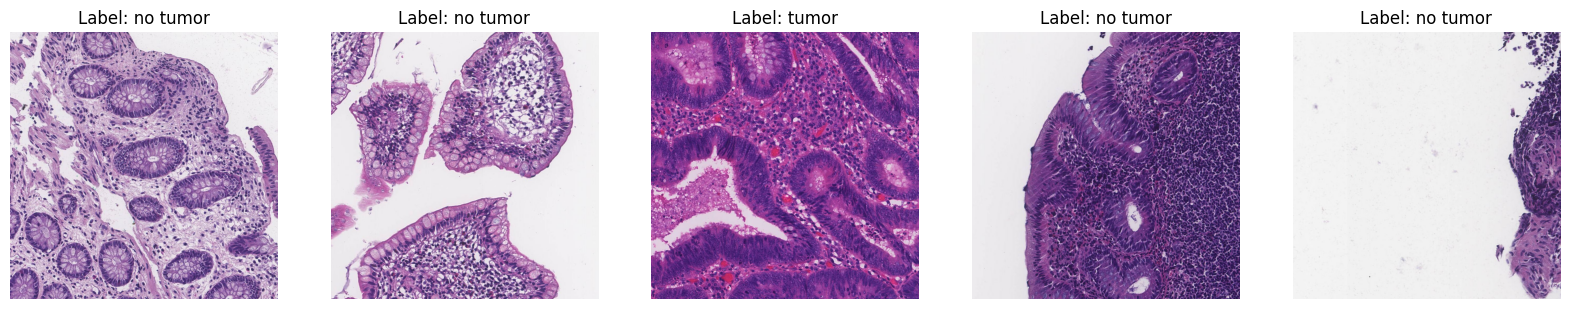

In [33]:
vis_data(5)

## Data Distribution

In [8]:
# Get the distribution of labels
label_distribution = df_labels['tumor'].value_counts()

# Display the label distribution
label_distribution

tumor
0    3767
1    1887
Name: count, dtype: int64

## Size and Color Distribution

In [9]:
def calc_size_and_color_dist():
    # Initialize lists to store the image properties
    widths = []
    heights = []
    means = []
    stds = []
    
    for img_file in tqdm(image_files):
        with Image.open(os.path.join(image_dir, img_file)) as img:
            # Convert the image to a NumPy array
            img_array = np.array(img)
    
            # Get the width and height of the image
            height, width, _ = img_array.shape
            widths.append(width)
            heights.append(height)
    
            # Calculate the mean and standard deviation of the image's color channels
            means.append(img_array.mean(axis=(0, 1)))
            stds.append(img_array.std(axis=(0, 1)))
    
    # Convert the lists to NumPy arrays
    widths = np.array(widths)
    heights = np.array(heights)
    means = np.array(means)
    stds = np.array(stds)
    
    # Calculate the average width, height, and color statistics
    avg_width = widths.mean()
    avg_height = heights.mean()
    avg_mean = means.mean(axis=0)
    avg_std = stds.mean(axis=0)
    
    avg_width, avg_height, avg_mean, avg_std

In [10]:
#calc_size_and_color_dist()

Result:
- Average width: 1024 pixels
- Average height: 1024 pixels
- Average color means (RGB): approximately [178.56474067, 145.60552567, 188.35602514]
- Average color standard deviations (RGB): approximately [49.86086508, 61.11946215, 39.38671275]

# Detailed Data Analysis

1. **Image Intensity Distributions:** Compare the distributions of pixel intensities between images labeled as "tumor" and those labeled as "no tumor". This could help identify whether tumors are associated with areas of particularly high or low intensity.
2. **Texture Analysis:** Tumors may change the texture of the tissue. Various texture features such as smoothness, coarseness, and regularity can be extracted and analyzed.
3. **Color Analysis:** While we've looked at the overall color mean and standard deviation, it might be informative to compare the color distributions of tumor and non-tumor images.
4. **Edge Analysis:** Tumors may cause the appearance of distinct edges in the tissue. Analyzing the presence and distribution of edges might be useful.
5. **Shape Analysis:** If tumors are clearly visible, they might have specific shapes that could be analyzed.

## Image Intensity Distributions

In [15]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

def process_batch(img_ids, image_dir):
    hist_batch = np.zeros(256, dtype=np.int64)
    
    for img_id in img_ids:
        with Image.open(os.path.join(image_dir, img_id)) as img:
            img_array = np.array(img.convert('L'))
            hist, _ = np.histogram(img_array, bins=256, range=(0, 256))
            hist_batch += hist

    return hist_batch

def vis_img_intensity_dist(num_images_per_class=None, batch_size=100):
    if num_images_per_class:
        tumor_img_ids = df_labels[df_labels['tumor'] == 1]['img_id'].sample(num_images_per_class, random_state=1).tolist()
        non_tumor_img_ids = df_labels[df_labels['tumor'] == 0]['img_id'].sample(num_images_per_class, random_state=1).tolist()
    else:
        tumor_img_ids = df_labels[df_labels['tumor'] == 1]['img_id'].tolist()
        non_tumor_img_ids = df_labels[df_labels['tumor'] == 0]['img_id'].tolist()

    hist_tumor = np.zeros(256, dtype=np.int64)
    hist_non_tumor = np.zeros(256, dtype=np.int64)

    for i in tqdm(range(0, len(tumor_img_ids), batch_size), desc="Processing Tumor Images"):
        hist_tumor += process_batch(tumor_img_ids[i:i+batch_size], image_dir)

    for i in tqdm(range(0, len(non_tumor_img_ids), batch_size), desc="Processing Non-Tumor Images"):
        hist_non_tumor += process_batch(non_tumor_img_ids[i:i+batch_size], image_dir)

    # Plot the intensity distributions
    plt.figure(figsize=(10, 6))
    plt.bar(range(256), hist_tumor, color='red', alpha=0.5, label='Tumor')
    plt.bar(range(256), hist_non_tumor, color='blue', alpha=0.5, label='Non-Tumor')
    plt.title('Intensity Distributions')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Processing Non-Tumor Images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:30<00:00,  2.39s/it]


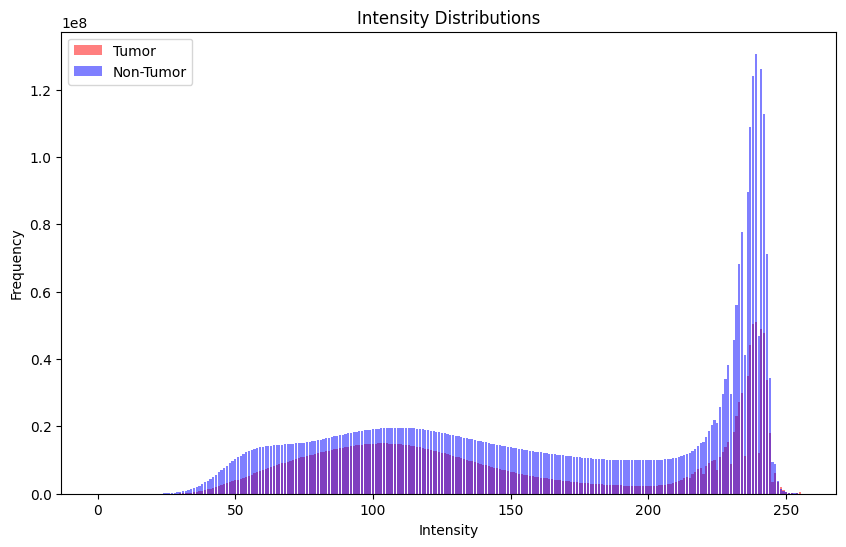

In [17]:
vis_img_intensity_dist()

## Color Analysis

In [18]:
num_images = 50

# Randomly select a subset of tumor and non-tumor image IDs from the filtered dataframe
tumor_img_ids = df_labels_filtered[df_labels['tumor'] == 1]['img_id'].sample(num_images, random_state=1)
non_tumor_img_ids = df_labels_filtered[df_labels['tumor'] == 0]['img_id'].sample(num_images, random_state=1)

# Get the file names for these image IDs
tumor_img_files = [f'{img_id}' for img_id in tumor_img_ids]
non_tumor_img_files = [f'{img_id}' for img_id in non_tumor_img_ids]

# Initialize lists to store the color channel intensities
tumor_colors = {'red': [], 'green': [], 'blue': []}
non_tumor_colors = {'red': [], 'green': [], 'blue': []}

def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

new_size = (256, 256)

# For each tumor image file
for img_file in tqdm(tumor_img_files):
    # Open the image file
    with Image.open(os.path.join(unzip_dir, img_file)) as img:
        # Resize the image
        img_resized = resize_image(img, new_size)

        # Convert the resized image to a NumPy array
        img_array = np.array(img_resized)

        # Add the color channel intensities to the lists
        for i, color in enumerate(tumor_colors):
            tumor_colors[color].extend(img_array[..., i].flatten())

# For each non-tumor image file
for img_file in tqdm(non_tumor_img_files):
    # Open the image file
    with Image.open(os.path.join(unzip_dir, img_file)) as img:
        # Resize the image
        img_resized = resize_image(img, new_size)

        # Convert the resized image to a NumPy array
        img_array = np.array(img_resized)

        # Add the color channel intensities to the lists
        for i, color in enumerate(non_tumor_colors):
            non_tumor_colors[color].extend(img_array[..., i].flatten())

# Convert the lists to NumPy arrays
for color in tumor_colors:
    tumor_colors[color] = np.array(tumor_colors[color])
for color in non_tumor_colors:
    non_tumor_colors[color] = np.array(non_tumor_colors[color])

# Plot the color distributions
plt.figure(figsize=(18, 6))

for i, color in enumerate(tumor_colors):
    plt.subplot(1, 3, i+1)
    plt.hist(tumor_colors[color], bins=256, color='red', alpha=0.5, label='Tumor')
    plt.hist(non_tumor_colors[color], bins=256, color='blue', alpha=0.5, label='Non-Tumor')
    plt.title(f'{color.capitalize()} Channel')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'tumor_img_files' is not defined